# Analysis on directors

#### In this notebook, we analyze directors and their gender distribution

### Loading CMU Corpus

In [1]:
CMU_PATH = "data/MovieSummaries"
IMDB_PATH = "data/imdb_data"

In [2]:
import wikipediaapi
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import gender_guesser.detector as gender
from tqdm import tqdm
from collections import Counter
from tqdm.contrib.concurrent import process_map 
from joblib import Parallel, delayed
from multiprocessing import Pool
from SPARQLWrapper import SPARQLWrapper, JSON
from src.utils.utils import assign_role_importance, country_female_ratio, role_man

ModuleNotFoundError: No module named 'wikipediaapi'

We load the csv we created from CMU data and imdb

In [3]:
metadata = pd.read_csv(f"data/merged_data.csv")

In [4]:
metadata

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date_x,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,tconst,...,gender,actors,first_role_actor,second_role_actor,third_role_actor,first_role_gender,second_role_gender,third_role_gender,F,M
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",tt0228333,...,"['F', 'M', 'F', 'M', 'F', 'F', 'M', 'F', 'M', ...","['Natasha Henstridge', 'Ice Cube', 'Pam Grier'...",Natasha Henstridge,Ice Cube,Pam Grier,F,M,F,2,1
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,['Norwegian Language'],['Norway'],"['Crime Fiction', 'Drama']",tt0094806,...,"['M', 'F', 'F', 'M', 'M', 'M', 'F', 'M', 'M', ...","['Frank Krog', 'Kristin Kajander', 'Anne Krigs...",Frank Krog,Kristin Kajander,Anne Krigsvoll,M,F,F,2,1
2,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,['English Language'],['United Kingdom'],"['Thriller', 'Erotic thriller', 'Psychological...",tt0094320,...,"['M', 'F', 'M', 'M', 'M', 'F', 'F', 'M', 'M', ...","['David Keith', 'Cathy Moriarty', 'Alan Rosenb...",David Keith,Cathy Moriarty,Alan Rosenberg,M,F,M,1,2
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,['German Language'],['Germany'],['Drama'],tt0083949,...,"['F', 'M', 'M', 'F', 'M', 'M', 'F', 'M', 'M', ...","['Gudrun Landgrebe', 'Mathieu Carrière', 'Hann...",Gudrun Landgrebe,Mathieu Carrière,Hanns Zischler,F,M,M,1,2
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,['English Language'],['United States of America'],"['Musical', 'Comedy', 'Black-and-white']",tt0029852,...,"['M', 'F', 'M', 'F', 'M', 'M', 'F', 'M', 'M', ...","['Tyrone Power', 'Alice Faye', 'Don Ameche', '...",Tyrone Power,Alice Faye,Don Ameche,M,F,M,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57117,23851782,/m/06_vb43,The Ghost Train,1941,NaN,82.0,['English Language'],['United Kingdom'],"['Crime Fiction', 'Thriller', 'Comedy', 'Super...",tt0033660,...,"['M', 'M', 'F', 'M', 'F', 'M', 'F', 'M', 'M', ...","['Arthur Askey', 'Richard Murdoch', 'Kathleen ...",Arthur Askey,Richard Murdoch,Kathleen Harrison,M,M,F,1,2
57118,32468537,/m/0crwd9y,Shadow Boxing 2,2007,NaN,132.0,"['Russian Language', 'English Language']",['Russia'],"['Sports', 'Crime Fiction', 'Action', 'Drama']",tt0459759,...,"['F', 'M', 'M', 'M', 'M', 'F', 'M', 'M', 'M', ...","['Elena Panova', 'Andrey Panin', 'Victor Hermi...",Elena Panova,Andrey Panin,Victor Herminio Lopez,F,M,M,1,2
57119,34980460,/m/0g4pl34,Knuckle,2011,NaN,96.0,['English Language'],"['Ireland', 'United Kingdom']","['Biographical film', 'Drama', 'Documentary']",tt1606259,...,"['M', 'M', 'M', 'M']","['James Quinn McDonagh', 'Paddy Quinn McDonagh...",James Quinn McDonagh,Paddy Quinn McDonagh,Michael Quinn McDonagh,M,M,M,0,3
57120,9971909,/m/02pygw1,Another Nice Mess,1972,NaN,66.0,['English Language'],['United States of America'],"['Satire', 'Comedy']",tt0362411,...,"['M', 'M', 'F', 'M', 'M', 'M', 'F', 'M', 'M', ...","['Rich Little', 'Herb Voland', 'Diahn Williams...",Rich Little,Herb Voland,Diahn Williams,M,M,F,1,2


We load the crew dataset from idmb

In [5]:
crew = pd.read_table(f"{IMDB_PATH}/title.crew.tsv")

crew

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,\N
3,tt0000004,nm0721526,\N
4,tt0000005,nm0005690,\N
...,...,...,...
10625491,tt9916848,nm1485677,"nm9187127,nm1485677,nm9826385,nm9299459,nm1628284"
10625492,tt9916850,nm1485677,"nm9187127,nm1485677,nm9826385,nm1628284"
10625493,tt9916852,nm1485677,"nm9187127,nm1485677,nm9826385,nm9299459,nm1628284"
10625494,tt9916856,nm10538645,nm6951431


We merge our crew dataset with metadata

In [6]:
crew = crew.merge(metadata, on="tconst", how="inner")

In [7]:
crew

,tconst,directors,writers,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date_x,Movie_box_office_revenue,Movie_runtime,Movie_languages,...,gender,actors,first_role_actor,second_role_actor,third_role_actor,first_role_gender,second_role_gender,third_role_gender,F,M
0,tt0000591,nm0141150,nm0141150,4849466,/m/07s67rr,L'Enfant prodigue,1907,NaN,90.0,['French Language'],...,"['M', 'M', 'F', 'F']","['Georges Wague', 'Henri Gouget', 'Christiane ...",Georges Wague,Henri Gouget,Christiane Mandelys,M,M,F,1,2
1,tt0000615,nm0533958,"nm0092809,nm0533958",32986669,/m/04p7yxx,Robbery Under Arms,1907,NaN,NaN,['Silent film'],...,"['M', 'M', 'M', 'M', 'M', 'F']","['Jim Gerald', 'George Merriman', 'Lance Vane'...",Jim Gerald,George Merriman,Lance Vane,M,M,M,0,3
2,tt0000679,"nm0091767,nm0877783","nm0000875,nm0877783",5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,NaN,120.0,['English Language'],...,"['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', ...","['L. Frank Baum', 'Frank Burns', 'George E. Wi...",L. Frank Baum,Frank Burns,George E. Wilson,M,M,M,0,3
3,tt0001101,nm0923603,\N,6334750,/m/0g1kr9,Abraham Lincoln's Clemency,1910,NaN,NaN,['English Language'],...,['M'],['Leopold Wharton'],Leopold Wharton,NaN,NaN,M,NaN,NaN,0,1
4,tt0001341,nm1024681,nm1024681,28149517,/m/0cmbf1t,Jarní sen starého mládence,1913,NaN,NaN,['Czech Language'],...,"['M', 'M', 'F', 'F', 'M', 'M']","['Josef Kricenský', 'Ferry Seidl', 'Berta Frie...",Josef Kricenský,Ferry Seidl,Berta Friedrichová,M,M,F,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57117,tt9815072,nm0445390,nm0445390,18475018,/m/04f2nb9,Pontianak Menjerit,2005,NaN,105.0,"['Malay Language', 'Thai Language']",...,"['F', 'M', 'M', 'F', 'M', 'M', 'F', 'M', 'F', ...","['Juliana Banos', 'Jalaluddin Hassan', 'Faizal...",Juliana Banos,Jalaluddin Hassan,Faizal Hussein,F,M,M,1,2
57118,tt9834564,nm0353721,nm1834334,22780907,/m/05zwjv0,Oshidori kenkagasa,1957,NaN,NaN,['Japanese Language'],...,"['M', 'F', 'M', 'M', 'M', 'M', 'F', 'M', 'M', ...","['Kôji Tsuruta', 'Hibari Misora', 'Akio Kobori...",Kôji Tsuruta,Hibari Misora,Akio Kobori,M,F,M,1,2
57119,tt9855214,nm0539034,"nm10511503,nm10511505,nm10511504",7316179,/m/0kv4t6,Kisan,2006,NaN,NaN,['Malayalam Language'],...,"['M', 'M', 'F', 'F', 'F', 'M', 'M', 'M', 'F', ...","['Kalabhavan Mani', 'Biju Menon', 'Bhavana', '...",Kalabhavan Mani,Biju Menon,Bhavana,M,M,F,1,2
57120,tt9881364,nm7843279,"nm7843279,nm0707494,nm2270180",17475562,/m/04g0_80,Gaja,2008,NaN,NaN,[],...,"['F', 'F', 'M', 'F', 'M', 'F', 'F', 'F', 'M', ...","['Ashalatha', 'Aruna Balraj', 'Devaraj', 'Bhav...",Ashalatha,Aruna Balraj,Devaraj,F,F,M,2,1


In [8]:
crew['directors'] = crew['directors'].replace("\\N", np.nan)

In [9]:
crew[crew["directors"].isnull()]

,tconst,directors,writers,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date_x,Movie_box_office_revenue,Movie_runtime,Movie_languages,...,gender,actors,first_role_actor,second_role_actor,third_role_actor,first_role_gender,second_role_gender,third_role_gender,F,M
109,tt0004667,NaN,\N,35261321,/m/0j7lhp1,Taking his Chance,1914,NaN,NaN,"['Silent film', 'English Language']",...,['F'],['Lottie Lyell'],Lottie Lyell,NaN,NaN,F,NaN,NaN,1,0
222,tt0006249,NaN,\N,35261105,/m/0j7kryj,We'll Take Her Children in Amongst Our Own,1915,NaN,NaN,"['Silent film', 'English Language']",...,['F'],['Lottie Lyell'],Lottie Lyell,NaN,NaN,F,NaN,NaN,1,0
306,tt0006996,NaN,"nm0535508,nm0000636",15097511,/m/03hh9c3,Macbeth,1915,NaN,NaN,['French Language'],...,"['M', 'F', 'M', 'M']","['Séverin-Mars', 'Georgette Leblanc', 'Pierre ...",Séverin-Mars,Georgette Leblanc,Pierre Alcover,M,F,M,1,2
569,tt0008984,NaN,nm0235323,13436659,/m/03c591c,Cupid Angling,1918,NaN,NaN,['English Language'],...,"['M', 'F']","['Albert Morrison', 'Ruth Roland']",Albert Morrison,Ruth Roland,NaN,M,F,NaN,1,1
12230,tt0051719,NaN,\N,20123164,/m/04y7qh2,The Hidden World,1958,NaN,NaN,['English Language'],...,['M'],['Gregory Peck'],Gregory Peck,NaN,NaN,M,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56911,tt6548518,NaN,\N,26208838,/m/0b77vwp,Thodi Kodallu,1957,NaN,NaN,['Telugu language'],...,['F'],['Saroja E.V.'],Saroja E.V.,NaN,NaN,F,NaN,NaN,1,0
56967,tt6925244,NaN,\N,30415996,/m/0g5sf7q,Graduate,2011,NaN,NaN,['Telugu language'],...,"['M', 'M']","['Brahmanandam', 'Manoj Chandra']",Brahmanandam,Manoj Chandra,NaN,M,M,NaN,0,2
56968,tt6925264,NaN,\N,33270310,/m/0h7r1h6,Kshetram,0,NaN,NaN,[],...,"['M', 'M', 'M']","['Jagapathi Babu', 'Brahmanandam', 'Shaam']",Jagapathi Babu,Brahmanandam,Shaam,M,M,M,0,3
56990,tt7450784,NaN,\N,23519606,/m/06w9_rf,Vedikkai En Vadikkai,1990,NaN,NaN,['Tamil Language'],...,"['M', 'M', 'F', 'M', 'F', 'F', 'F', 'M', 'F', ...","['M.S. Bhaskar', 'Dilip', 'Divya', 'Kishmu', '...",M.S. Bhaskar,Dilip,Divya,M,M,F,1,2


In [10]:
import time
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd  # Assuming `crew` is a pandas DataFrame

# Initialize SPARQL endpoint
endpoint_url = "https://query.wikidata.org/sparql"
sparql = SPARQLWrapper(endpoint_url)

def batch_query_wikidata(imdb_ids):
    """
    Query Wikidata for directors given a batch of IMDb IDs.
    """
    # Build SPARQL query
    values_clause = " ".join(f'"{imdb_id}"' for imdb_id in imdb_ids)
    query = f"""
    SELECT ?imdbID ?director ?directorLabel WHERE {{
      VALUES ?imdbID {{{values_clause}}}
      ?movie wdt:P345 ?imdbID;           # IMDb ID property
             wdt:P57 ?director.          # Director property
      SERVICE wikibase:label {{
        bd:serviceParam wikibase:language "en".  # English labels
      }}
    }}
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    
    # Parse results into a dictionary
    directors_info = {}
    for result in results["results"]["bindings"]:
        imdb_id = result["imdbID"]["value"]
        director_name = result["directorLabel"]["value"]
        if imdb_id not in directors_info:
            directors_info[imdb_id] = []
        directors_info[imdb_id].append({"director": director_name})
    return directors_info

def process_batch_with_backoff(batch, retries=5):
    """
    Process a batch of IMDb IDs with exponential backoff in case of errors.
    """
    wait_time = 1  # Initial wait time in seconds
    for attempt in range(retries):
        try:
            return batch_query_wikidata(batch)
        except Exception as e:
            print(f"Error: {e}. Retrying in {wait_time} seconds... (Attempt {attempt + 1}/{retries})")
            time.sleep(wait_time)
            wait_time *= 2  # Exponential backoff
    print(f"Failed to process batch after {retries} retries.")
    return {}

# Load IMDb IDs from DataFrame
imdb_ids = crew.loc[crew['directors'].isna(), 'tconst'].tolist()

# Split IMDb IDs into manageable batches
batch_size = 20  # Reduced batch size to avoid rate limits
batched_ids = [imdb_ids[i:i + batch_size] for i in range(0, len(imdb_ids), batch_size)]

# Initialize list to log failed batches
failed_batches = []

# Process each batch
for batch in batched_ids:
    print(f"Processing batch: {batch}")
    directors_data = process_batch_with_backoff(batch)
    
    # Update the DataFrame with the retrieved data
    for imdb_id, directors in directors_data.items():
        try:
            row_index = crew[crew['tconst'] == imdb_id].index[0]
            crew.at[row_index, 'directors'] = ", ".join(d['director'] for d in directors)
        except Exception as e:
            print(f"Error updating IMDb ID {imdb_id}: {e}")
            failed_batches.append(batch)

    # Pause between batches to avoid hitting rate limits
    time.sleep(5)  # Increased delay between batches

# Retry any failed batches
if failed_batches:
    print("Retrying failed batches...")
    for batch in failed_batches:
        print(f"Retrying batch: {batch}")
        directors_data = process_batch_with_backoff(batch)
        for imdb_id, directors in directors_data.items():
            try:
                row_index = crew[crew['tconst'] == imdb_id].index[0]
                crew.at[row_index, 'directors'] = ", ".join(d['director'] for d in directors)
            except Exception as e:
                print(f"Failed again for IMDb ID {imdb_id}: {e}")

print("Batch processing complete!")


Processing batch: ['tt0004667', 'tt0006249', 'tt0006996', 'tt0008984', 'tt0051719', 'tt0055313', 'tt0068834', 'tt0072703', 'tt0137811', 'tt0166220', 'tt0182993', 'tt0185893', 'tt0197077', 'tt0224364', 'tt0246877', 'tt0247283', 'tt0250486', 'tt0274019', 'tt0274566', 'tt0280997']
Processing batch: ['tt0281116', 'tt0292192', 'tt0296893', 'tt0312714', 'tt0314385', 'tt0314521', 'tt0315735', 'tt0316404', 'tt0318015', 'tt0319645', 'tt0319808', 'tt0320617', 'tt0328395', 'tt0331567', 'tt0336573', 'tt0346931', 'tt0347595', 'tt0349182', 'tt0350678', 'tt0351784']
Processing batch: ['tt0353777', 'tt0361753', 'tt0370765', 'tt0371870', 'tt0372549', 'tt0373244', 'tt0377126', 'tt0381050', 'tt0385515', 'tt0402305', 'tt0438054', 'tt0483559', 'tt0497710', 'tt0887254', 'tt0904079', 'tt0997281', 'tt1059311', 'tt1067580', 'tt10681962', 'tt1279240']
Processing batch: ['tt13613000', 'tt13818954', 'tt14189060', 'tt14350400', 'tt14630666', 'tt14630674', 'tt14652506', 'tt14653694', 'tt14653732', 'tt14852902', 'tt

In [11]:
crew.directors.isnull().sum()

74

We can see that we have some missing values.

In [12]:
crew[crew.directors.isnull()]

,tconst,directors,writers,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date_x,Movie_box_office_revenue,Movie_runtime,Movie_languages,...,gender,actors,first_role_actor,second_role_actor,third_role_actor,first_role_gender,second_role_gender,third_role_gender,F,M
306,tt0006996,NaN,"nm0535508,nm0000636",15097511,/m/03hh9c3,Macbeth,1915,NaN,NaN,['French Language'],...,"['M', 'F', 'M', 'M']","['Séverin-Mars', 'Georgette Leblanc', 'Pierre ...",Séverin-Mars,Georgette Leblanc,Pierre Alcover,M,F,M,1,2
12230,tt0051719,NaN,\N,20123164,/m/04y7qh2,The Hidden World,1958,NaN,NaN,['English Language'],...,['M'],['Gregory Peck'],Gregory Peck,NaN,NaN,M,NaN,NaN,0,1
17633,tt0068834,NaN,\N,18916948,/m/04jkrxj,The Last Target,0,NaN,NaN,[],...,['M'],['Michael Redgrave'],Michael Redgrave,NaN,NaN,M,NaN,NaN,0,1
30192,tt0137811,NaN,\N,33839507,/m/0hn96b_,Her Triumph,1915,NaN,NaN,[],...,"['F', 'M']","['Gaby Deslys', 'Harry Pilcer']",Gaby Deslys,Harry Pilcer,NaN,F,M,NaN,1,1
33059,tt0182993,NaN,\N,21450473,/m/05f6yb7,Wakanohana monogatari dohyou no oni,1992,NaN,NaN,['Japanese Language'],...,['M'],['Tetsuo Kurata'],Tetsuo Kurata,NaN,NaN,M,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56889,tt6448760,NaN,\N,13180192,/m/02zbfx3,Tholaipesi,2007,NaN,NaN,['Tamil Language'],...,['F'],['Archana Suseelan'],Archana Suseelan,NaN,NaN,F,NaN,NaN,1,0
56903,tt6450176,NaN,\N,17489405,/m/0479g_h,1977,2008,NaN,NaN,['Tamil Language'],...,"['F', 'M', 'F', 'F', 'M', 'M', 'M', 'M']","['Farzana Barucha', 'Ilavarasu', 'Jayasudha', ...",Farzana Barucha,Ilavarasu,Jayasudha,F,M,F,2,1
56967,tt6925244,NaN,\N,30415996,/m/0g5sf7q,Graduate,2011,NaN,NaN,['Telugu language'],...,"['M', 'M']","['Brahmanandam', 'Manoj Chandra']",Brahmanandam,Manoj Chandra,NaN,M,M,NaN,0,2
56968,tt6925264,NaN,\N,33270310,/m/0h7r1h6,Kshetram,0,NaN,NaN,[],...,"['M', 'M', 'M']","['Jagapathi Babu', 'Brahmanandam', 'Shaam']",Jagapathi Babu,Brahmanandam,Shaam,M,M,M,0,3


We can see that these movies overall contain many missing values. To simplify the analysis, we decide to drop them. 

In [13]:
crew = crew.dropna(subset=["directors"])

In [14]:
crew['directors'] = crew['directors'].str.split(',')

crew_long = crew.explode('directors')

crew_long = crew_long.reset_index(drop=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_2344\1423380569.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crew['directors'] = crew['directors'].str.split(',')


In [15]:
crew_long

,tconst,directors,writers,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date_x,Movie_box_office_revenue,Movie_runtime,Movie_languages,...,gender,actors,first_role_actor,second_role_actor,third_role_actor,first_role_gender,second_role_gender,third_role_gender,F,M
0,tt0000591,nm0141150,nm0141150,4849466,/m/07s67rr,L'Enfant prodigue,1907,NaN,90.0,['French Language'],...,"['M', 'M', 'F', 'F']","['Georges Wague', 'Henri Gouget', 'Christiane ...",Georges Wague,Henri Gouget,Christiane Mandelys,M,M,F,1,2
1,tt0000615,nm0533958,"nm0092809,nm0533958",32986669,/m/04p7yxx,Robbery Under Arms,1907,NaN,NaN,['Silent film'],...,"['M', 'M', 'M', 'M', 'M', 'F']","['Jim Gerald', 'George Merriman', 'Lance Vane'...",Jim Gerald,George Merriman,Lance Vane,M,M,M,0,3
2,tt0000679,nm0091767,"nm0000875,nm0877783",5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,NaN,120.0,['English Language'],...,"['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', ...","['L. Frank Baum', 'Frank Burns', 'George E. Wi...",L. Frank Baum,Frank Burns,George E. Wilson,M,M,M,0,3
3,tt0000679,nm0877783,"nm0000875,nm0877783",5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,NaN,120.0,['English Language'],...,"['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', ...","['L. Frank Baum', 'Frank Burns', 'George E. Wi...",L. Frank Baum,Frank Burns,George E. Wilson,M,M,M,0,3
4,tt0001101,nm0923603,\N,6334750,/m/0g1kr9,Abraham Lincoln's Clemency,1910,NaN,NaN,['English Language'],...,['M'],['Leopold Wharton'],Leopold Wharton,NaN,NaN,M,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62075,tt9815072,nm0445390,nm0445390,18475018,/m/04f2nb9,Pontianak Menjerit,2005,NaN,105.0,"['Malay Language', 'Thai Language']",...,"['F', 'M', 'M', 'F', 'M', 'M', 'F', 'M', 'F', ...","['Juliana Banos', 'Jalaluddin Hassan', 'Faizal...",Juliana Banos,Jalaluddin Hassan,Faizal Hussein,F,M,M,1,2
62076,tt9834564,nm0353721,nm1834334,22780907,/m/05zwjv0,Oshidori kenkagasa,1957,NaN,NaN,['Japanese Language'],...,"['M', 'F', 'M', 'M', 'M', 'M', 'F', 'M', 'M', ...","['Kôji Tsuruta', 'Hibari Misora', 'Akio Kobori...",Kôji Tsuruta,Hibari Misora,Akio Kobori,M,F,M,1,2
62077,tt9855214,nm0539034,"nm10511503,nm10511505,nm10511504",7316179,/m/0kv4t6,Kisan,2006,NaN,NaN,['Malayalam Language'],...,"['M', 'M', 'F', 'F', 'F', 'M', 'M', 'M', 'F', ...","['Kalabhavan Mani', 'Biju Menon', 'Bhavana', '...",Kalabhavan Mani,Biju Menon,Bhavana,M,M,F,1,2
62078,tt9881364,nm7843279,"nm7843279,nm0707494,nm2270180",17475562,/m/04g0_80,Gaja,2008,NaN,NaN,[],...,"['F', 'F', 'M', 'F', 'M', 'F', 'F', 'F', 'M', ...","['Ashalatha', 'Aruna Balraj', 'Devaraj', 'Bhav...",Ashalatha,Aruna Balraj,Devaraj,F,F,M,2,1


In [53]:
crew_long_unique = crew_long.drop_duplicates(subset=["directors"])

We load the name dataset to map the crew nconst to the name

In [16]:
imdb_names = pd.read_csv(f"{IMDB_PATH}/name.basics.tsv", sep="\t", engine = "pyarrow")

In [17]:
imdb_names

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer","tt0050419,tt0072308,tt0053137,tt0027125"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack,archive_footage","tt0037382,tt0075213,tt0117057,tt0038355"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,music_department,producer","tt0057345,tt0049189,tt0056404,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,writer,music_department","tt0072562,tt0077975,tt0080455,tt0078723"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0069467,tt0050976,tt0083922"
...,...,...,...,...,...,...
13944213,nm9993714,Romeo del Rosario,\N,\N,"animation_department,art_department","tt11657662,tt14069590,tt2455546"
13944214,nm9993716,Essias Loberg,\N,\N,\N,\N
13944215,nm9993717,Harikrishnan Rajan,\N,\N,cinematographer,tt8736744
13944216,nm9993718,Aayush Nair,\N,\N,cinematographer,tt8736744


In [20]:
imdb_names

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer","tt0050419,tt0072308,tt0053137,tt0027125"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack,archive_footage","tt0037382,tt0075213,tt0117057,tt0038355"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,music_department,producer","tt0057345,tt0049189,tt0056404,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,writer,music_department","tt0072562,tt0077975,tt0080455,tt0078723"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0069467,tt0050976,tt0083922"
...,...,...,...,...,...,...
13944213,nm9993714,Romeo del Rosario,\N,\N,"animation_department,art_department","tt11657662,tt14069590,tt2455546"
13944214,nm9993716,Essias Loberg,\N,\N,\N,\N
13944215,nm9993717,Harikrishnan Rajan,\N,\N,cinematographer,tt8736744
13944216,nm9993718,Aayush Nair,\N,\N,cinematographer,tt8736744


In [21]:
imdb_names = imdb_names.rename(columns={"nconst": "directors"})

In [23]:
crew_long = crew_long.merge(imdb_names[['directors', 'primaryName', "birthYear", "deathYear"]], on="directors", how="left")


In [24]:
crew_long.head()

,tconst,directors,writers,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date_x,Movie_box_office_revenue,Movie_runtime,Movie_languages,...,second_role_actor,third_role_actor,first_role_gender,second_role_gender,third_role_gender,F,M,primaryName,birthYear,deathYear
0,tt0000591,nm0141150,nm0141150,4849466,/m/07s67rr,L'Enfant prodigue,1907,NaN,90.0,['French Language'],...,Henri Gouget,Christiane Mandelys,M,M,F,1,2,Michel Carré,1865,1945
1,tt0000615,nm0533958,"nm0092809,nm0533958",32986669,/m/04p7yxx,Robbery Under Arms,1907,NaN,NaN,['Silent film'],...,George Merriman,Lance Vane,M,M,M,0,3,Charles MacMahon,1861,1917
2,tt0000679,nm0091767,"nm0000875,nm0877783",5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,NaN,120.0,['English Language'],...,Frank Burns,George E. Wilson,M,M,M,0,3,Francis Boggs,1870,1911
3,tt0000679,nm0877783,"nm0000875,nm0877783",5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,NaN,120.0,['English Language'],...,Frank Burns,George E. Wilson,M,M,M,0,3,Otis Turner,1862,1918
4,tt0001101,nm0923603,\N,6334750,/m/0g1kr9,Abraham Lincoln's Clemency,1910,NaN,NaN,['English Language'],...,NaN,NaN,M,NaN,NaN,0,1,Theodore Wharton,1875,1931


In [26]:
crew_long[crew_long.primaryName.isnull()]

,tconst,directors,writers,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date_x,Movie_box_office_revenue,Movie_runtime,Movie_languages,...,second_role_actor,third_role_actor,first_role_gender,second_role_gender,third_role_gender,F,M,primaryName,birthYear,deathYear
134,tt0004667,Raymond Longford,\N,35261321,/m/0j7lhp1,Taking his Chance,1914,NaN,NaN,"['Silent film', 'English Language']",...,NaN,NaN,F,NaN,NaN,1,0,NaN,NaN,NaN
270,tt0006249,Raymond Longford,\N,35261105,/m/0j7kryj,We'll Take Her Children in Amongst Our Own,1915,NaN,NaN,"['Silent film', 'English Language']",...,NaN,NaN,F,NaN,NaN,1,0,NaN,NaN,NaN
673,tt0008984,Louis William Chaudet,nm0235323,13436659,/m/03c591c,Cupid Angling,1918,NaN,NaN,['English Language'],...,Ruth Roland,NaN,M,F,NaN,1,1,NaN,NaN,NaN
14909,tt0055313,Milan Vošmik,"nm0389348,nm0435079",28379474,/m/0crjdmc,Pohádka o staré tramvaji,1961,NaN,NaN,['Czech Language'],...,Zdenek Deyl,Eman Fiala,F,M,M,1,2,NaN,NaN,NaN
19492,tt0068846,nm16784584,"nm0000419,nm0330948",3404048,/m/099qsr,Letter to Jane,1972,NaN,52.0,"['French Language', 'English Language']",...,Jean-Pierre Gorin,NaN,M,M,NaN,0,2,NaN,NaN,NaN
20566,tt0072703,Irwin Rosten,nm0637498,22586257,/m/05zkwp5,"Birds Do It, Bees Do It",1974,NaN,90.0,['English Language'],...,NaN,NaN,M,NaN,NaN,0,1,NaN,NaN,NaN
20567,tt0072703,Nicolas Noxon,nm0637498,22586257,/m/05zkwp5,"Birds Do It, Bees Do It",1974,NaN,90.0,['English Language'],...,NaN,NaN,M,NaN,NaN,0,1,NaN,NaN,NaN
34659,tt0166220,Friz Freleng,\N,1606658,/m/05g512,The House That Shadows Built,1931,NaN,55.0,['English Language'],...,Harpo Marx,Chico Marx,M,M,M,0,3,NaN,NaN,NaN
39557,tt0246877,Selva,\N,25349953,/m/09g88kx,Pudhayal,1997,NaN,NaN,['Tamil Language'],...,Sakshi Shivanand,Arvind Swamy,M,F,M,1,2,NaN,NaN,NaN
39806,tt0250486,Wilfred Noy,"nm0116107,nm0855139",32071900,/m/0gwz74c,The Lady Clare,1919,NaN,NaN,['English Language'],...,Jack Hobbs,Charles Quatermaine,F,M,M,1,2,NaN,NaN,NaN


In [27]:
crew_long["primaryName"] = crew_long["primaryName"].fillna(crew_long["directors"])

In [29]:
crew_long = crew_long.drop("directors", axis = 1)
crew_long = crew_long.rename(columns={"primaryName": "director"})

In [30]:
crew_long

,tconst,writers,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date_x,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,...,second_role_actor,third_role_actor,first_role_gender,second_role_gender,third_role_gender,F,M,director,birthYear,deathYear
0,tt0000591,nm0141150,4849466,/m/07s67rr,L'Enfant prodigue,1907,NaN,90.0,['French Language'],['France'],...,Henri Gouget,Christiane Mandelys,M,M,F,1,2,Michel Carré,1865,1945
1,tt0000615,"nm0092809,nm0533958",32986669,/m/04p7yxx,Robbery Under Arms,1907,NaN,NaN,['Silent film'],['Australia'],...,George Merriman,Lance Vane,M,M,M,0,3,Charles MacMahon,1861,1917
2,tt0000679,"nm0000875,nm0877783",5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,NaN,120.0,['English Language'],['United States of America'],...,Frank Burns,George E. Wilson,M,M,M,0,3,Francis Boggs,1870,1911
3,tt0000679,"nm0000875,nm0877783",5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,NaN,120.0,['English Language'],['United States of America'],...,Frank Burns,George E. Wilson,M,M,M,0,3,Otis Turner,1862,1918
4,tt0001101,\N,6334750,/m/0g1kr9,Abraham Lincoln's Clemency,1910,NaN,NaN,['English Language'],['United States of America'],...,NaN,NaN,M,NaN,NaN,0,1,Theodore Wharton,1875,1931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62075,tt9815072,nm0445390,18475018,/m/04f2nb9,Pontianak Menjerit,2005,NaN,105.0,"['Malay Language', 'Thai Language']",['Malaysia'],...,Jalaluddin Hassan,Faizal Hussein,F,M,M,1,2,Yusof Kelana,\N,2020
62076,tt9834564,nm1834334,22780907,/m/05zwjv0,Oshidori kenkagasa,1957,NaN,NaN,['Japanese Language'],['Japan'],...,Hibari Misora,Akio Kobori,M,F,M,1,2,Ryô Hagiwara,\N,\N
62077,tt9855214,"nm10511503,nm10511505,nm10511504",7316179,/m/0kv4t6,Kisan,2006,NaN,NaN,['Malayalam Language'],['India'],...,Biju Menon,Bhavana,M,M,F,1,2,Sibi Malayil,1956,\N
62078,tt9881364,"nm7843279,nm0707494,nm2270180",17475562,/m/04g0_80,Gaja,2008,NaN,NaN,[],['India'],...,Aruna Balraj,Devaraj,F,F,M,2,1,K. Madesh,\N,\N


Now, we find the directors gender

In [38]:
import time
import random
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
from urllib.error import HTTPError

# Initialize SPARQL wrapper with the Wikidata endpoint
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

# Function to run a paginated query with retry logic
def fetch_data(offset, limit=100):
    max_retries = 5  # Maximum number of retries
    backoff_factor = 2  # Exponential backoff multiplier
    retry_delay = 2  # Initial delay in seconds

    for attempt in range(max_retries):
        try:
            sparql.setQuery(f"""
            SELECT DISTINCT
              ?filmDirector ?filmDirectorLabel ?gender ?genderLabel
            WHERE 
            {{
              ?filmDirector p:P106 ?statement1.
              ?statement1 (ps:P106/(wdt:P279*)) wd:Q2526255. # Find all items with a particular profession (director)
              OPTIONAL {{?filmDirector wdt:P21 ?gender.}}      
              SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
            }}
            LIMIT {limit}
            OFFSET {offset}
            """)
            
            sparql.setReturnFormat(JSON)
            results = sparql.query().convert()
            
            # Extract data into a list of dictionaries
            data = []
            for result in results["results"]["bindings"]:
                data.append({
                    "filmDirector": result.get("filmDirectorLabel", {}).get("value", None),
                    "gender": result.get("genderLabel", {}).get("value", None),
                })
            return data
        
        except HTTPError as e:
            if e.code == 429:  # Too Many Requests
                if attempt < max_retries - 1:  # Retry logic
                    delay = retry_delay * (backoff_factor ** attempt)
                    print(f"HTTP 429: Retrying in {delay:.2f} seconds...")
                    time.sleep(delay + random.uniform(0, 1))  # Add jitter to avoid synchronized retries
                else:
                    print("Max retries reached. Exiting.")
                    raise
            else:
                raise

# Initialize the DataFrame
all_data = []

# Number of results per chunk
chunk_size = 10000
offset = 0

# Keep fetching until there is no data left
while True:
    print(f"Fetching data with OFFSET {offset}...")
    try:
        chunk_data = fetch_data(offset, chunk_size)
        
        if not chunk_data:  # If no data is returned, break the loop
            break
        
        # Append the current chunk to the overall data list
        all_data.extend(chunk_data)
        
        # Increase the offset for the next batch of results
        offset += chunk_size
    except Exception as e:
        print(f"Error during data fetch: {e}")
        break

# Create a pandas DataFrame from all collected data
film_director_gender = pd.DataFrame(all_data)


Fetching data with OFFSET 0...
HTTP 429: Retrying in 2.00 seconds...
Fetching data with OFFSET 10000...
Fetching data with OFFSET 20000...
Fetching data with OFFSET 30000...
Fetching data with OFFSET 40000...
Fetching data with OFFSET 50000...
Fetching data with OFFSET 60000...
Fetching data with OFFSET 70000...
Fetching data with OFFSET 80000...
HTTP 429: Retrying in 2.00 seconds...
Fetching data with OFFSET 90000...
Fetching data with OFFSET 100000...


In [39]:
film_director_gender = film_director_gender.rename(columns={"filmDirector": "director"})

In [43]:
crew_long = crew_long.merge(film_director_gender, on="director",  how="left")

In [53]:
crew_long = crew_long.rename(columns={"gender_x": "gender_actors", "gender": "gender_directors"})

In [56]:
crew_long.gender_directors.isna().sum()

18677

In [57]:
crew_long

,tconst,writers,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date_x,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,...,third_role_actor,first_role_gender,second_role_gender,third_role_gender,F,M,director,birthYear,deathYear,gender_directors
0,tt0000591,nm0141150,4849466,/m/07s67rr,L'Enfant prodigue,1907,NaN,90.0,['French Language'],['France'],...,Christiane Mandelys,M,M,F,1,2,Michel Carré,1865,1945,male
1,tt0000615,"nm0092809,nm0533958",32986669,/m/04p7yxx,Robbery Under Arms,1907,NaN,NaN,['Silent film'],['Australia'],...,Lance Vane,M,M,M,0,3,Charles MacMahon,1861,1917,male
2,tt0000679,"nm0000875,nm0877783",5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,NaN,120.0,['English Language'],['United States of America'],...,George E. Wilson,M,M,M,0,3,Francis Boggs,1870,1911,male
3,tt0000679,"nm0000875,nm0877783",5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,NaN,120.0,['English Language'],['United States of America'],...,George E. Wilson,M,M,M,0,3,Otis Turner,1862,1918,male
4,tt0001101,\N,6334750,/m/0g1kr9,Abraham Lincoln's Clemency,1910,NaN,NaN,['English Language'],['United States of America'],...,NaN,M,NaN,NaN,0,1,Theodore Wharton,1875,1931,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70980,tt9815072,nm0445390,18475018,/m/04f2nb9,Pontianak Menjerit,2005,NaN,105.0,"['Malay Language', 'Thai Language']",['Malaysia'],...,Faizal Hussein,F,M,M,1,2,Yusof Kelana,\N,2020,male
70981,tt9834564,nm1834334,22780907,/m/05zwjv0,Oshidori kenkagasa,1957,NaN,NaN,['Japanese Language'],['Japan'],...,Akio Kobori,M,F,M,1,2,Ryô Hagiwara,\N,\N,NaN
70982,tt9855214,"nm10511503,nm10511505,nm10511504",7316179,/m/0kv4t6,Kisan,2006,NaN,NaN,['Malayalam Language'],['India'],...,Bhavana,M,M,F,1,2,Sibi Malayil,1956,\N,male
70983,tt9881364,"nm7843279,nm0707494,nm2270180",17475562,/m/04g0_80,Gaja,2008,NaN,NaN,[],['India'],...,Devaraj,F,F,M,2,1,K. Madesh,\N,\N,NaN


In [60]:
crew_long[crew_long.director.duplicated(keep="first")].groupby("director").count().sort_values("tconst", ascending=False)

,tconst,writers,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date_x,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,...,second_role_actor,third_role_actor,first_role_gender,second_role_gender,third_role_gender,F,M,birthYear,deathYear,gender_directors
director,,,,,,,,,,,,,,,,,,,,,
Mario Mattoli,169,169,169,169,169,169,0,157,169,169,...,169,169,169,169,169,169,169,169,169,169
Raoul Walsh,165,165,165,165,165,165,42,161,165,165,...,165,165,165,165,165,165,165,165,165,165
Michael Curtiz,160,160,160,160,160,160,16,115,160,160,...,160,158,160,160,158,160,160,160,160,160
Sam Newfield,145,145,145,145,145,145,0,137,145,145,...,145,145,145,145,145,145,145,145,145,145
Cecil B. DeMille,139,139,139,139,139,139,10,108,139,139,...,139,139,139,139,139,139,139,139,139,139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hanumappa Vishwanath Babu,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,0
Hansol Shin,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
Paul Auster,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [70]:
non_attributed = crew_long[crew_long.gender_directors.isnull()]

In [71]:
non_attributed = non_attributed.drop_duplicates(subset=["director"])

In [72]:
# Initialize Wikipedia API for French and English with user-agent
wiki_fr = wikipediaapi.Wikipedia("MyProjectName (merlin@example.com)", 'fr')
wiki_en = wikipediaapi.Wikipedia("MyProjectName (merlin@example.com)", 'en')

def get_gender_from_genderize(name):
    """Use Genderize.io to predict gender from a first name."""
    api_url = f"https://api.genderize.io/?name={name}"
    try:
        response = requests.get(api_url)
        if response.status_code == 200:
            result = response.json()
            gender = result.get('gender')
            if gender == 'male' or gender == 'female':
                return gender, 'Genderize.io'
    except Exception as e:
        print(f"Error fetching data from Genderize.io: {e}")
    return np.nan, 'Unknown'

def get_gender_from_namsor(first_name, last_name):
    """Determine gender using NamSor API."""
    url = "https://v2.namsor.com/NamSorAPIv2/api2/json/genderBatch"
    headers = {
        "X-API-KEY": "INSERT API KEY HERE FROM NAMSOR",
        "Accept": "application/json",
        "Content-Type": "application/json"
    }
    payload = {
        "personalNames": [
            {
                "id": "unique-id",  # Unique identifier for the entry
                "firstName": first_name,
                "lastName": last_name
            }
        ]
    }
    try:
        response = requests.post(url, json=payload, headers=headers)
        if response.status_code == 200:
            data = response.json()
            if 'personalNames' in data and len(data['personalNames']) > 0:
                person = data['personalNames'][0]
                return person.get('likelyGender'), 'NamSor'
    except Exception as e:
        print(f"Error fetching data from NamSor API: {e}")
    return np.nan, 'Unknown'


def get_gender_from_wikipedia(name):
    """Determine gender using the French and English Wikipedia pages."""
    # Search in French Wikipedia
    page_fr = wiki_fr.page(name)
    if page_fr.exists():
        content_fr = page_fr.text.lower()
        if 'profession' in content_fr:
            if 'réalisateur' in content_fr or 'producteur' in content_fr:
                return 'male', 'Wikipedia French'
            elif 'réalisatrice' in content_fr or 'productrice' in content_fr:
                return 'female', 'Wikipedia French'
        elif 'réalisateur' in content_fr or 'réalisatrice' in content_fr:
            if 'réalisateur' in content_fr:
                return 'male', 'Wikipedia French'                         
            elif 'réalisatrice' in content_fr:
                return 'female', 'Wikipedia French'

    # Search in English Wikipedia
    page_en = wiki_en.page(name)
    if page_en.exists():
        content_en = page_en.text.lower()
        male_keywords = ['he', 'him', 'his', 'himself']
        female_keywords = ['she', 'her', 'hers', 'herself']
        male_count = sum(content_en.count(word) for word in male_keywords)
        female_count = sum(content_en.count(word) for word in female_keywords)
        if male_count > female_count:
            return 'male', 'Wikipedia English'
        elif female_count > male_count:
            return 'female', 'Wikipedia English'

    # Fallback to gender_guesser
    d = gender.Detector()
    guessed_gender = d.get_gender(name.split()[0])  # Use first name
    if guessed_gender in ['male', 'mostly_male']:
        return 'male', 'Gender Guesser'
    elif guessed_gender in ['female', 'mostly_female']:
        return 'female', 'Gender Guesser'

    # Fallback to Genderize.io
    return get_gender_from_namsor(name.split()[0], name.split()[-1])

def process_gender_row_dict(row):
    """Process gender for a single row represented as a dictionary."""
    name, current_gender = row['director'], row['gender_directors']
    if pd.isna(current_gender):  # Check if the current gender is NaN
        gender, source = get_gender_from_wikipedia(name)
        return {'Gender': gender, 'Gender Source': source}
    return {'Gender': current_gender, 'Gender Source': 'Existing'}

def process_parallel_with_joblib(data, n_cores=4):
    """Parallel processing using joblib."""
    # Convert DataFrame to list of dictionaries
    rows = data.to_dict(orient='records')

    # Use Parallel + delayed for parallel processing
    results = Parallel(n_jobs=n_cores)(
        delayed(process_gender_row_dict)(row) for row in tqdm(rows, desc="Processing")
    )

    # Convert the list of dictionaries back to a DataFrame
    results_df = pd.DataFrame(results)
    return pd.concat([data.reset_index(drop=True), results_df], axis=1)

if __name__ == "__main__":
    # Assuming non_attributed is your DataFrame
    n_cores = 8  # Adjust based on your system's capabilities
    non_attributed = process_parallel_with_joblib(non_attributed, n_cores=n_cores)

    # Save the results
    print("Gender assignment for sample completed and saved.")

    

Processing: 100%|██████████| 8250/8250 [11:41<00:00, 11.76it/s]


Gender assignment for sample completed and saved.


In [74]:
non_attributed.Gender.value_counts()

Gender
male      7480
female     770
Name: count, dtype: int64

In [21]:
non_attributed["Gender Source"].value_counts()

Gender Source
Gender Guesser       3002
Wikipedia English    1845
NamSor               1645
Wikipedia French     1609
Name: count, dtype: int64

In [77]:
non_attributed_cleaned = non_attributed[["director", "Gender"]]

In [275]:
crew_merged = crew_long.merge(non_attributed_cleaned, on="director", how="left")

In [276]:
crew_merged

,tconst,writers,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date_x,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,...,first_role_gender,second_role_gender,third_role_gender,F,M,director,birthYear,deathYear,gender_directors,Gender
0,tt0000591,nm0141150,4849466,/m/07s67rr,L'Enfant prodigue,1907,NaN,90.0,['French Language'],['France'],...,M,M,F,1,2,Michel Carré,1865,1945,male,NaN
1,tt0000615,"nm0092809,nm0533958",32986669,/m/04p7yxx,Robbery Under Arms,1907,NaN,NaN,['Silent film'],['Australia'],...,M,M,M,0,3,Charles MacMahon,1861,1917,male,NaN
2,tt0000679,"nm0000875,nm0877783",5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,NaN,120.0,['English Language'],['United States of America'],...,M,M,M,0,3,Francis Boggs,1870,1911,male,NaN
3,tt0000679,"nm0000875,nm0877783",5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,NaN,120.0,['English Language'],['United States of America'],...,M,M,M,0,3,Otis Turner,1862,1918,male,NaN
4,tt0001101,\N,6334750,/m/0g1kr9,Abraham Lincoln's Clemency,1910,NaN,NaN,['English Language'],['United States of America'],...,M,NaN,NaN,0,1,Theodore Wharton,1875,1931,male,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70980,tt9815072,nm0445390,18475018,/m/04f2nb9,Pontianak Menjerit,2005,NaN,105.0,"['Malay Language', 'Thai Language']",['Malaysia'],...,F,M,M,1,2,Yusof Kelana,\N,2020,male,NaN
70981,tt9834564,nm1834334,22780907,/m/05zwjv0,Oshidori kenkagasa,1957,NaN,NaN,['Japanese Language'],['Japan'],...,M,F,M,1,2,Ryô Hagiwara,\N,\N,NaN,male
70982,tt9855214,"nm10511503,nm10511505,nm10511504",7316179,/m/0kv4t6,Kisan,2006,NaN,NaN,['Malayalam Language'],['India'],...,M,M,F,1,2,Sibi Malayil,1956,\N,male,NaN
70983,tt9881364,"nm7843279,nm0707494,nm2270180",17475562,/m/04g0_80,Gaja,2008,NaN,NaN,[],['India'],...,F,F,M,2,1,K. Madesh,\N,\N,NaN,male


In [277]:
crew_merged.columns

Index(['tconst', 'writers', 'Wikipedia movie ID', 'Freebase_movie_ID',
       'Movie_name', 'Movie_release_date_x', 'Movie_box_office_revenue',
       'Movie_runtime', 'Movie_languages', 'Movie_countries', 'Movie_genres',
       'isAdult', 'Movie_release_date_y', 'genres', 'gender_actors', 'actors',
       'first_role_actor', 'second_role_actor', 'third_role_actor',
       'first_role_gender', 'second_role_gender', 'third_role_gender', 'F',
       'M', 'director', 'birthYear', 'deathYear', 'gender_directors',
       'Gender'],
      dtype='object')

In [278]:
crew_merged['gender_directors'] = crew_merged['gender_directors'].fillna(crew_merged['Gender'])    

In [279]:
crew_merged = crew_merged.drop("Gender", axis=1)
crew_merged

,tconst,writers,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date_x,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,...,third_role_actor,first_role_gender,second_role_gender,third_role_gender,F,M,director,birthYear,deathYear,gender_directors
0,tt0000591,nm0141150,4849466,/m/07s67rr,L'Enfant prodigue,1907,NaN,90.0,['French Language'],['France'],...,Christiane Mandelys,M,M,F,1,2,Michel Carré,1865,1945,male
1,tt0000615,"nm0092809,nm0533958",32986669,/m/04p7yxx,Robbery Under Arms,1907,NaN,NaN,['Silent film'],['Australia'],...,Lance Vane,M,M,M,0,3,Charles MacMahon,1861,1917,male
2,tt0000679,"nm0000875,nm0877783",5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,NaN,120.0,['English Language'],['United States of America'],...,George E. Wilson,M,M,M,0,3,Francis Boggs,1870,1911,male
3,tt0000679,"nm0000875,nm0877783",5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,NaN,120.0,['English Language'],['United States of America'],...,George E. Wilson,M,M,M,0,3,Otis Turner,1862,1918,male
4,tt0001101,\N,6334750,/m/0g1kr9,Abraham Lincoln's Clemency,1910,NaN,NaN,['English Language'],['United States of America'],...,NaN,M,NaN,NaN,0,1,Theodore Wharton,1875,1931,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70980,tt9815072,nm0445390,18475018,/m/04f2nb9,Pontianak Menjerit,2005,NaN,105.0,"['Malay Language', 'Thai Language']",['Malaysia'],...,Faizal Hussein,F,M,M,1,2,Yusof Kelana,\N,2020,male
70981,tt9834564,nm1834334,22780907,/m/05zwjv0,Oshidori kenkagasa,1957,NaN,NaN,['Japanese Language'],['Japan'],...,Akio Kobori,M,F,M,1,2,Ryô Hagiwara,\N,\N,male
70982,tt9855214,"nm10511503,nm10511505,nm10511504",7316179,/m/0kv4t6,Kisan,2006,NaN,NaN,['Malayalam Language'],['India'],...,Bhavana,M,M,F,1,2,Sibi Malayil,1956,\N,male
70983,tt9881364,"nm7843279,nm0707494,nm2270180",17475562,/m/04g0_80,Gaja,2008,NaN,NaN,[],['India'],...,Devaraj,F,F,M,2,1,K. Madesh,\N,\N,male


In [58]:
crew_merged.gender_directors.isna().sum()

0

In [281]:
crew_merged.columns

Index(['tconst', 'writers', 'Wikipedia movie ID', 'Freebase_movie_ID',
       'Movie_name', 'Movie_release_date_x', 'Movie_box_office_revenue',
       'Movie_runtime', 'Movie_languages', 'Movie_countries', 'Movie_genres',
       'isAdult', 'Movie_release_date_y', 'genres', 'gender_actors', 'actors',
       'first_role_actor', 'second_role_actor', 'third_role_actor',
       'first_role_gender', 'second_role_gender', 'third_role_gender', 'F',
       'M', 'director', 'birthYear', 'deathYear', 'gender_directors'],
      dtype='object')

In [282]:
for i in crew_merged["Movie_release_date_x"].value_counts().index:
    print(i)

0
2008
2007
2006
2009
2010
2011
2005
2004
2003
2002
2012
2001
2000
1999
1998
1997
1965
1996
1995
1993
1994
1989
1988
1987
1972
1990
1991
1985
1952
1971
1992
1951
1973
1984
1981
1986
1962
1968
1980
1974
1978
1969
1976
1950
1970
1979
1983
1982
1967
1964
1957
1977
1958
1975
1953
1955
1956
1960
1936
1959
1937
1940
1954
1961
1939
1938
1949
1966
1934
1963
1935
1942
1941
1948
1932
1933
1943
1947
1931
1944
1945
1946
1930
1929
1928
1927
1926
1917
1916
1924
1921
1923
1925
1922
1919
1918
1915
2013
1914
1920
1913
1911
1912
2014
1910
2016
2015
1903
1908
1907


In [283]:
crew_merged.Movie_release_date_x.isna().sum()

0

In [284]:
for i in crew_merged["Movie_release_date_y"].value_counts().index:
    print(i)

2008
2007
2006
2009
2010
2011
2005
2004
2003
2002
2001
2012
2000
1999
1998
1995
1997
1989
1988
1996
1965
1987
1994
1972
1993
1991
1971
1990
1984
1973
1986
1992
1952
1951
1985
1970
1981
1980
1979
1975
1977
1978
1974
1964
1962
1976
1982
1967
1957
1968
1969
1953
1958
1950
1956
1983
1955
1960
1936
1961
1954
1959
1966
1934
1937
1949
1963
1939
1940
1938
1935
1932
1948
1942
1933
1941
1931
1943
1947
1944
1945
1946
1930
2013
1929
1928
1927
1917
1926
1923
1924
1925
1921
1916
1922
1919
1918
1915
1914
1920
2014
2015
1913
1911
1912
2016
2018
2017
0
2019
2021
1903
1910
2022
1907
2020
1908
2024
2025


In [285]:
crew_merged["Movie_release_date_y"].value_counts()

Movie_release_date_y
2008    1957
2007    1928
2006    1904
2009    1887
2010    1823
        ... 
1907       2
2020       2
1908       2
2024       1
2025       1
Name: count, Length: 119, dtype: int64

In [286]:
crew_merged["Movie_release_date_x"] = crew_merged["Movie_release_date_x"].apply(lambda x: x if x != 0 else np.nan)

In [287]:
crew_merged["Movie_release_date_x"] = crew_merged["Movie_release_date_x"].fillna(crew_merged["Movie_release_date_y"])
crew_merged["Movie_release_date_x"].isna().sum()

0

In [288]:
crew_merged = crew_merged.drop("Movie_release_date_y", axis=1)

In [289]:
crew_merged = crew_merged.rename(columns={"Movie_release_date_x": "Movie_release_date"})

In [290]:
print(crew_merged['Movie_release_date'].unique())

[1907. 1908. 1910. 1913. 1911. 1912. 1914. 1916. 1915. 1919. 1917. 1918.
 1930. 1920. 1921. 1922. 1923. 1924. 1925. 1926. 1935. 1927. 1928. 1929.
 1931. 1939. 1932. 1933. 1951. 1934. 1948. 1937. 1936. 1941. 1947. 1938.
 1940. 2006. 1942. 1944. 1990. 1943. 1950. 1952. 2001. 1945. 1949. 1946.
 1973. 1953. 1960. 1958. 1954. 1955. 1961. 1977. 1957. 1956. 2005. 2000.
 1968. 1959. 1962. 1964. 1963. 1974. 1972. 1965. 1966. 1970. 1967. 1969.
 1980. 1979. 2008. 1981. 1978. 1971. 2004. 1989. 2003. 1975. 1976. 1982.
 2002. 1984. 1983. 1988. 2007. 1996. 1993. 1985. 1987. 1997. 1998. 1986.
 1995. 1991. 2011. 1999. 1992. 1994. 2010. 1903. 2009. 2012. 2018. 2015.
 2014. 2016. 2019. 2013.    0. 2022. 2025. 2017.]


In [291]:
crew_merged[crew_merged['Movie_release_date'] == 0]

,tconst,writers,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,...,third_role_actor,first_role_gender,second_role_gender,third_role_gender,F,M,director,birthYear,deathYear,gender_directors
58877,tt0808372,"nm1951398,nm2081046,nm0463620",5121174,/m/0d3n25,Metal Gear Solid,0.0,NaN,NaN,"['French Language', 'Japanese Language', 'Engl...","['United States of America', 'Japan']",...,NaN,M,NaN,NaN,0,1,Jordan Vogt-Roberts,1984,\N,male
63025,tt1240952,"nm0289696,nm3067697,nm2053173",27277059,/m/0bwkqtt,Empires of the Deep,0.0,NaN,NaN,[],[],...,Davy Williams,F,F,M,2,1,Michael French,\N,\N,male
63026,tt1240952,"nm0289696,nm3067697,nm2053173",27277059,/m/0bwkqtt,Empires of the Deep,0.0,NaN,NaN,[],[],...,Davy Williams,F,F,M,2,1,Jonathan Lawrence,\N,\N,male
63027,tt1240952,"nm0289696,nm3067697,nm2053173",27277059,/m/0bwkqtt,Empires of the Deep,0.0,NaN,NaN,[],[],...,Davy Williams,F,F,M,2,1,Scott Miller,\N,\N,male
69845,tt2417504,nm5291683,33561300,/m/0hgq0mv,498A: The Wedding Gift,0.0,NaN,NaN,[],[],...,Supriya Karnik,M,F,F,2,1,Suhaib Ilyasi,\N,\N,male
70031,tt2793006,"nm5587240,nm5827238",33354076,/m/0h7qyxh,Kaptaan,0.0,NaN,NaN,[],['Pakistan'],...,Abdul Mannan,F,F,M,2,1,Faisal Aman Khan,\N,\N,male
70843,tt7612654,nm3342905,31308475,/m/0gj9zwk,Pendulum Drift,0.0,NaN,NaN,[],['Scotland'],...,Marta Benvenuty,F,M,F,2,1,Shehzad Afzal,\N,\N,male


In [292]:
crew_merged = crew_merged[crew_merged['Movie_release_date'] != 0]

In [293]:
crew_merged["Movie_release_date"] = crew_merged["Movie_release_date"].astype(int)

In [294]:
crew_merged["Movie_release_date"]

0        1907
1        1907
2        1908
3        1908
4        1910
         ... 
70980    2005
70981    1957
70982    2006
70983    2008
70984    1961
Name: Movie_release_date, Length: 70978, dtype: int32

In [75]:
crew_merged["Movie_release_date"] = pd.to_datetime(crew_merged['Movie_release_date'], format = "%Y").dt.year

In [76]:
crew_merged = crew_merged[crew_merged['gender_directors'].isin(['male', 'female'])]

In [77]:
crew_merged.columns

Index(['tconst', 'writers', 'Wikipedia movie ID', 'Freebase_movie_ID',
       'Movie_name', 'Movie_release_date', 'Movie_box_office_revenue',
       'Movie_runtime', 'Movie_languages', 'Movie_countries', 'Movie_genres',
       'isAdult', 'genres', 'gender_actors', 'actors', 'first_role_actor',
       'second_role_actor', 'third_role_actor', 'first_role_gender',
       'second_role_gender', 'third_role_gender', 'F', 'M', 'director',
       'birthYear', 'deathYear', 'gender_directors', 'release_year_bin'],
      dtype='object')

In [78]:
# crew_merged.to_csv("data/crew_gender.csv", index=False)
crew_merged = pd.read_csv("data/crew_gender.csv")

C:\Users\USER\AppData\Local\Temp\ipykernel_5912\2052290029.py:2: DtypeWarning:

Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.



In [79]:
crew_merged["genres"] = crew_merged["genres"].apply(lambda x: x if (x != r"\\N" and x!= r"\N" and x!= r"/N" and x!=r"//N") else np.nan)

In [80]:
import ast

# Convert string representations of lists to actual Python lists
crew_merged['Movie_countries'] = crew_merged['Movie_countries'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)



In [81]:
crew_merged['genres'] = crew_merged['genres'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

In [82]:
crew_merged_unique = crew_merged.drop_duplicates(subset=["director"]).reset_index(drop= True)

In [83]:
crew_merged_unique.head()

,tconst,writers,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,...,first_role_gender,second_role_gender,third_role_gender,F,M,director,birthYear,deathYear,gender_directors,release_year_bin
0,tt0000591,nm0141150,4849466,/m/07s67rr,L'Enfant prodigue,1907,NaN,90.0,['French Language'],[United States of America],...,M,M,F,1,2,Michel Carré,1865,1945,male,1905
1,tt0000615,"nm0092809,nm0533958",32986669,/m/04p7yxx,Robbery Under Arms,1907,NaN,NaN,['Silent film'],[Norway],...,M,M,M,0,3,Charles MacMahon,1861,1917,male,1905
2,tt0000679,"nm0000875,nm0877783",5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,NaN,120.0,['English Language'],[United Kingdom],...,M,M,M,0,3,Francis Boggs,1870,1911,male,1905
3,tt0000679,"nm0000875,nm0877783",5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,NaN,120.0,['English Language'],[Germany],...,M,M,M,0,3,Otis Turner,1862,1918,male,1905
4,tt0001101,\N,6334750,/m/0g1kr9,Abraham Lincoln's Clemency,1910,NaN,NaN,['English Language'],[United States of America],...,M,NaN,NaN,0,1,Theodore Wharton,1875,1931,male,1910


C:\Users\USER\AppData\Local\Temp\ipykernel_5912\4254106605.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




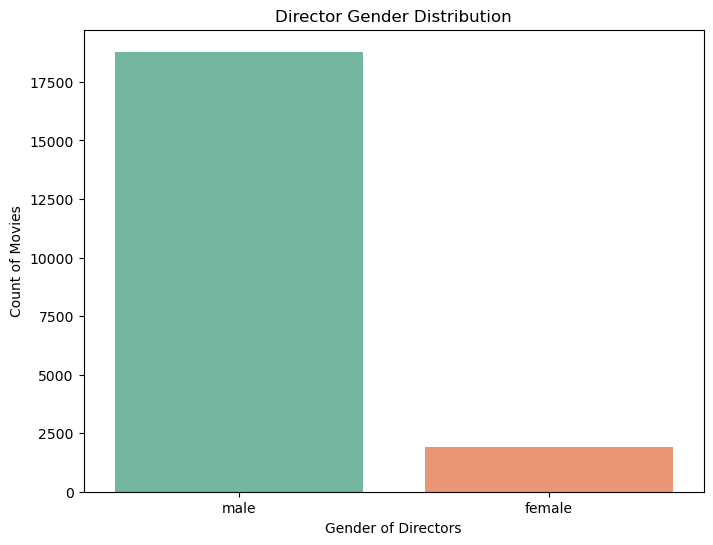

In [84]:
plt.figure(figsize=(8, 6))
sns.countplot(x='gender_directors', data=crew_merged_unique, palette="Set2")
plt.title('Director Gender Distribution')
plt.xlabel('Gender of Directors')
plt.ylabel('Count of Movies')
plt.show()

In [85]:
# # Create a new column for 5-year bins
# crew_merged['release_year_bin'] = (crew_merged['Movie_release_date'] // 5) * 5

# # Plotting Director Gender by 5-Year Release Bins
# plt.figure(figsize=(12, 8))
# sns.countplot(x='release_year_bin', hue='gender_directors', data=crew_merged)
# plt.title('Director Gender by 5-Year Release Bins')
# plt.xlabel('Release Year (5-Year Bins)')
# plt.ylabel('Count of Movies')
# plt.xticks(rotation=90)
# plt.show()

In [86]:
crew_merged['release_year_bin'] = (crew_merged['Movie_release_date'] // 5) * 5

# Calculate the total count of directors by 5-year bins and the count of female directors
gender_counts = crew_merged.groupby(['release_year_bin', 'gender_directors']).size().unstack(fill_value=0)
gender_counts['total'] = gender_counts.sum(axis=1)

# Calculate the proportion of female directors for each 5-year bin
gender_counts['female_proportion'] = gender_counts['female'] / gender_counts['total']

bar_trace_female = go.Bar(
    x=gender_counts.index,
    y=gender_counts['female'],
    name='Female Directors',
    marker=dict(color='pink')
)

bar_trace_male = go.Bar(
    x=gender_counts.index,
    y=gender_counts['male'],
    name='Male Directors',
    marker=dict(color='lightblue')
)

line_trace = go.Scatter(
    x=gender_counts.index,
    y=gender_counts['female_proportion'],
    mode='lines+markers',
    name='Female Proportion',
    line=dict(color='red', width=2),
    yaxis='y2'
)

layout = go.Layout(
    title='Director Gender by 5-Year Release Bins with Female Proportion',
    xaxis=dict(title='Release Year (5-Year Bins)'),
    yaxis=dict(title='Count of Movies'),
    yaxis2=dict(
        title='Female Proportion',
        overlaying= 'y',
        side='right',
        range=[0, 1]
    ),
    barmode='stack', 
    legend=dict(x=0.84, y=1)
)

fig = go.Figure(data=[bar_trace_female, bar_trace_male, line_trace], layout=layout)

# Show the plot
fig.show()


In [87]:
# Exploding the 'Movie_countries' column to get one row per country per director
df_exploded = crew_merged.explode('Movie_countries')
df_exploded = df_exploded.reset_index(drop=True)

# Count occurrences of each gender for each country
country_gender_counts = df_exploded.groupby(['Movie_countries', 'gender_directors']).size().reset_index(name='count')

# Sort by total counts across countries and select top 10 countries
top_10_countries = country_gender_counts.groupby('Movie_countries')['count'].sum().nlargest(10).index

# Filter the data to keep only the top 10 countries
top_10_data = country_gender_counts[country_gender_counts['Movie_countries'].isin(top_10_countries)]

# Ensure both genders are included for each country, even if the count is zero for one gender
top_10_data_pivot = top_10_data.pivot_table(index='Movie_countries', columns='gender_directors', values='count', aggfunc='sum', fill_value=0)

# Calculate the total number of directors (male + female) for each country
top_10_data_pivot['total'] = top_10_data_pivot.sum(axis=1)

# Calculate the female count and female proportion (female / total)
female_counts = top_10_data_pivot['female']
female_proportion = female_counts / top_10_data_pivot['total']

# Sort countries by total count (male + female) in descending order
top_10_data_pivot = top_10_data_pivot.sort_values(by='total', ascending=False)

bar_trace_female = go.Bar(
    x=top_10_data_pivot.index,
    y=top_10_data_pivot['female'],
    name='Female Directors',
    marker=dict(color='pink')
)

bar_trace_male = go.Bar(
    x=top_10_data_pivot.index,
    y=top_10_data_pivot['male'],
    name='Male Directors',
    marker=dict(color='lightblue')
)


line_trace = go.Scatter(
    x=top_10_data_pivot.index,  
    y=female_proportion.values,
    mode='lines+markers',
    name='Female Proportion',
    line=dict(color='red', width=2),
    yaxis='y2'
)


layout = go.Layout(
    title='Director Gender by Country (Top 10)',
    xaxis=dict(title='Country'),
    yaxis=dict(title='Count'),
    yaxis2=dict(
        title='Female Proportion',
        overlaying='y',
        side='right',
        range=[0, 0.1] 
    ),
    barmode='stack', 
    legend=dict(
        x=1.05, 
        y=1.1,   
        traceorder='normal',
        orientation='v',
        xanchor='left',   
        yanchor='top'    
    )
)

fig = go.Figure(data=[bar_trace_female, bar_trace_male, line_trace], layout=layout)

# Show the plot
fig.show()


In [88]:
# Exploding the 'genres' column to get one row per genre per director
df_exploded_genres = crew_merged.explode('genres')
df_exploded_genres = df_exploded_genres.reset_index(drop=True)

# Count occurrences of each gender for each genre
genre_gender_counts = df_exploded_genres.groupby(['genres', 'gender_directors']).size().reset_index(name='count')

# Sort by total counts across genres and select top 10 genres
top_10_genres = genre_gender_counts.groupby('genres')['count'].sum().nlargest(10).index

# Filter the data to keep only the top 10 genres
top_10_genre_data = genre_gender_counts[genre_gender_counts['genres'].isin(top_10_genres)]

# Ensure both genders are included for each genre, even if the count is zero for one gender
top_10_genre_data_pivot = top_10_genre_data.pivot_table(index='genres', columns='gender_directors', values='count', aggfunc='sum', fill_value=0)

# Calculate the total number of directors (male + female) for each genre
top_10_genre_data_pivot['total'] = top_10_genre_data_pivot.sum(axis=1)

# Calculate the female count and female proportion (female / total)
female_counts = top_10_genre_data_pivot['female']
female_proportion = female_counts / top_10_genre_data_pivot['total']

# Sort genres by total count (male + female) in descending order
top_10_genre_data_pivot = top_10_genre_data_pivot.sort_values(by='total', ascending=False)

bar_trace_female = go.Bar(
    x=top_10_genre_data_pivot.index,
    y=top_10_genre_data_pivot['female'],
    name='Female Directors',
    marker=dict(color='pink')
)

bar_trace_male = go.Bar(
    x=top_10_genre_data_pivot.index,
    y=top_10_genre_data_pivot['male'],
    name='Male Directors',
    marker=dict(color='lightblue')
)

line_trace = go.Scatter(
    x=top_10_genre_data_pivot.index,  
    y=female_proportion.values,
    mode='lines+markers',
    name='Female Proportion',
    line=dict(color='red', width=2),
    yaxis='y2'
)

layout = go.Layout(
    title='Director Gender by Genre (Top 10)',
    xaxis=dict(title='Genre'),
    yaxis=dict(title='Count'),
    yaxis2=dict(
        title='Female Proportion',
        overlaying='y',
        side='right',
        range=[0, 1] 
    ),
    barmode='stack',
    legend=dict(
        x=1.05,  
        y=1.1,    
        traceorder='normal',
        orientation='v',  
        xanchor='left',  
        yanchor='top'   
    )
)

fig = go.Figure(data=[bar_trace_female, bar_trace_male, line_trace], layout=layout)

# Show the plot
fig.show()


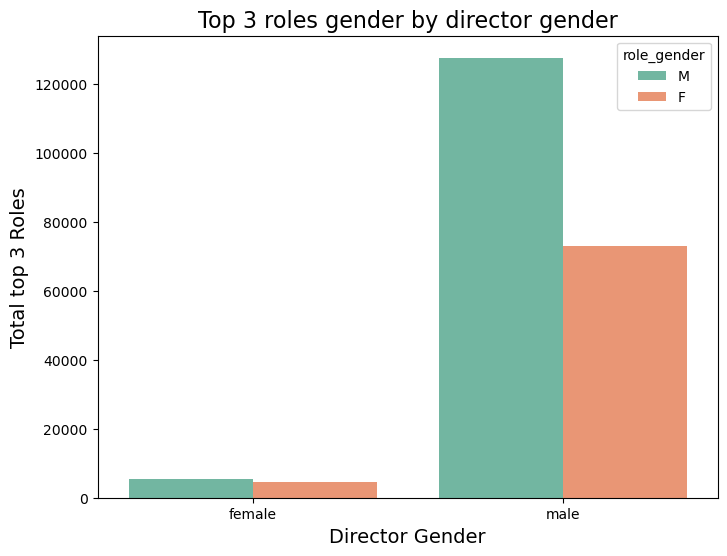

In [89]:

# Group by director gender and sum up the female (F) and male (M) first roles
gender_role_counts = crew_merged.groupby('gender_directors')[['F', 'M']].sum().reset_index()

# Plotting
plt.figure(figsize=(8, 6))
gender_role_counts_melted = gender_role_counts.melt(id_vars='gender_directors', value_vars=['M', 'F'], 
                                                    var_name='role_gender', value_name='count')

sns.barplot(x='gender_directors', y='count', hue='role_gender', data=gender_role_counts_melted, palette="Set2", hue_order=['M', 'F'])
plt.title('Top 3 roles gender by director gender', fontsize=16)
plt.xlabel('Director Gender', fontsize=14)
plt.ylabel('Total top 3 Roles', fontsize=14)
plt.show()


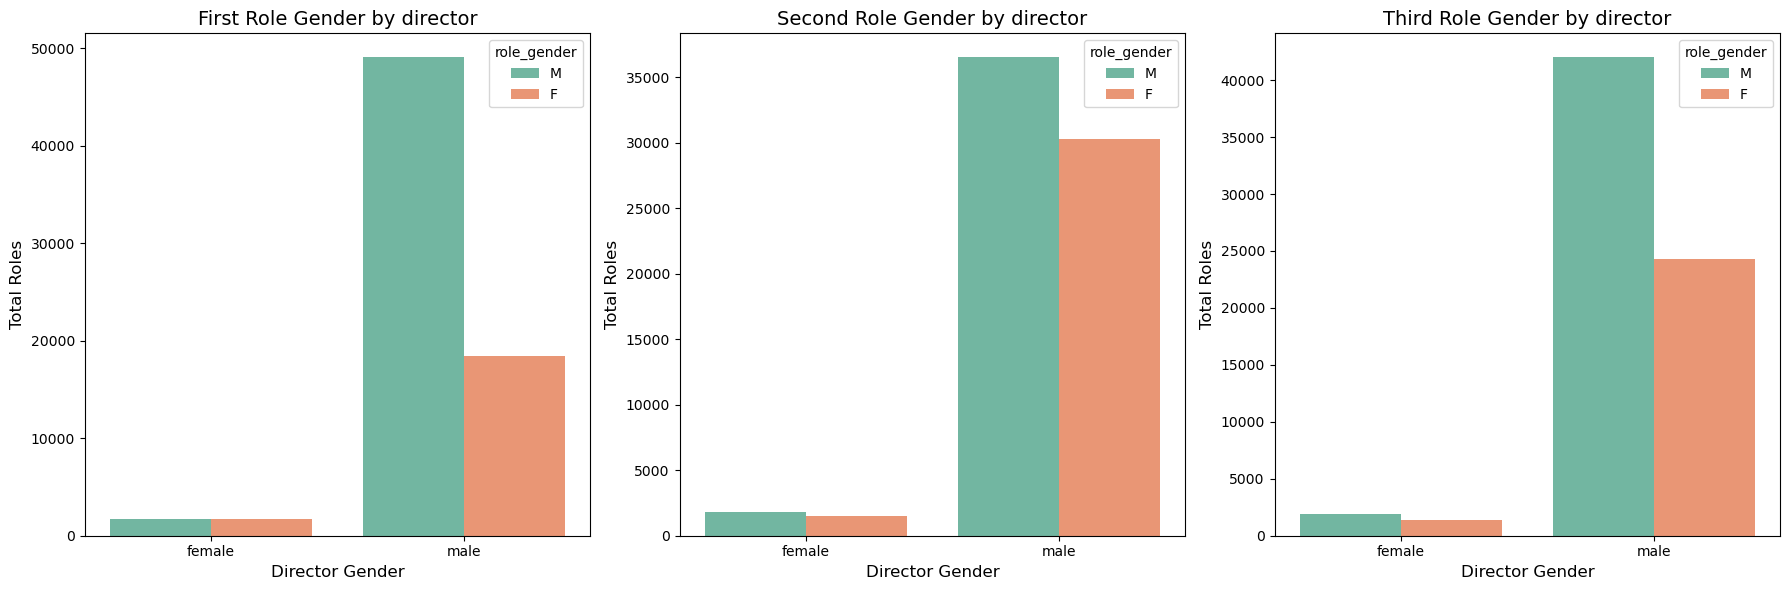

In [90]:
role_columns = ['first_role_gender', 'second_role_gender', 'third_role_gender']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, role in enumerate(role_columns):
    role_counts = crew_merged.groupby('gender_directors')[role].value_counts().unstack(fill_value=0).reset_index()

    role_counts_melted = role_counts.melt(id_vars='gender_directors', value_vars=['M', 'F'], 
                                          var_name='role_gender', value_name='count')

    sns.barplot(x='gender_directors', y='count', hue='role_gender', data=role_counts_melted, 
                palette="Set2", hue_order=['M', 'F'], ax=axes[i])
    
    axes[i].set_title(f'{role.replace("_", " ").title()} by director', fontsize=14)
    axes[i].set_xlabel('Director Gender', fontsize=12)
    axes[i].set_ylabel('Total Roles', fontsize=12)
    # axes[i].set_yscale('log')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


In [91]:
crew_merged.isna().sum()

tconst                          0
writers                         0
Wikipedia movie ID              0
Freebase_movie_ID               0
Movie_name                      0
Movie_release_date              0
Movie_box_office_revenue    60969
Movie_runtime               14463
Movie_languages                 0
Movie_countries             13843
Movie_genres                    0
isAdult                         0
genres                       1816
gender_actors                   0
actors                          0
first_role_actor                0
second_role_actor             879
third_role_actor             1370
first_role_gender               0
second_role_gender            879
third_role_gender            1370
F                               0
M                               0
director                        0
birthYear                      74
deathYear                      74
gender_directors                0
release_year_bin                0
dtype: int64

Fix plots

Box office

Do analysis by director and not just counts

do a scatter pot for the things by year

Combine ratio plots with previous ones

Mean Age

Hypothesis testing

